In [ ]:
import tensorflow as tf


import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
import os
path = '/content/drive/MyDrive/Deep Learning/Image captioning'
# load and unzip dataset

os.chdir(path)
!unzip Flickr8k_text.zip


Archive:  Flickr8k_text.zip
replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Function Loads caption training data from text file
def load_doc(filename):
  file = open(filename, 'r')

  text = file.read()
  file.close()
  return text

filename = 'Flickr8k.token.txt'

doc = load_doc(filename)

In [ ]:

img_path = '/content/drive/MyDrive/Deep Learning/Image captioning/image data/Flicker8k_Dataset'
def load_descriptions(doc):
  # processes caption text and adds <start> and <end> to each.
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    if '.npy' in image_id:
      image_id = os.path.join(img_path, (image_id.split('.npy')[0]))
      image_id = image_id + '.npy'
    else:
      image_id  =  os.path.join(img_path, (image_id.split('.jpg')[0]))
      image_id  = image_id + '.jpg'
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    #image_desc = f'<start> {image_desc} <end>'
    # create the list if needed
    if not os.path.exists(image_id):
      continue
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  return mapping

image_path_to_captions = load_descriptions(doc)

In [ ]:
import string
# REmove punctuations , change to lowercase, remove words with one character, remove words with numbers on them .

def clean_descriptions(descriptions):
  # prepare translation table for punctuation
  #table = str.maketrans('','', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      #desc = [w.translate(table) for w in desc]
      # removing hanging 's' and 'a'
      desc = [word for word in desc if len(word) > 1]
      # remove tokens with numbers in  them
      desc = [word for word in desc if word.isalpha()]
      #store as string
      desc = ' '.join(desc)
      desc_list[i] = f'<start> {desc} <end>'

#clean descriptions
clean_descriptions(image_path_to_captions)


In [ ]:
image_paths = list(image_path_to_captions.keys())

In [ ]:
random.shuffle(image_paths)

train_image_paths = image_paths[:7000]
test_image_paths = image_paths[7000:]

train_captions = []
img_name_vector = []

for image_path in image_paths: #train_image_paths:
  caption_list = image_path_to_captions[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> bunch of people playing soccer <end>
<start> action photo of soccer players in red and black uniforms <end>


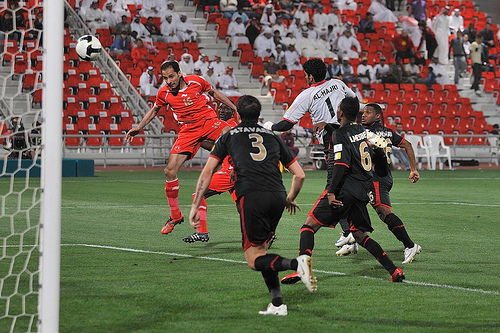

In [ ]:
print(train_captions[0])
print(train_captions[1])
Image.open(img_name_vector[0])

In [ ]:
os.chdir(os.curdir)
# Load image_caption_model.py gotten from image_caption_model.ipynb
from image_caption_model import *

In [ ]:
# Resize image to 299px by 299px and preprocess input by normalizing pixel in thre range of -1 to 1 which is necessarry for inceptionV3.
inception_model = load_model()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
def load_image(image_path):
    #Function loads pretrained inception model and preprocesses image.
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path



# # Get unique images
# encode_train = sorted(set(img_name_vector))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map( load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# count = 0
# for img, path in image_dataset:
#   # temp = path + '.npy'
#   # print(temp)
#   # if os.path.exists(temp):
#   #   continue
#   batch_features = inception_model(img)
#   batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode('utf-8')
#     np.save(path_of_feature, bf.numpy())
#   count += 1

# print(f'Processed only {count} image(s)')

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(image_path_to_captions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8359


In [ ]:
# Tokenize captions
# Limit vocabulary to 5000 words and replace the others with 'UNK'
# create a word-to-index and index-to-word mappings.
# Pad all sequences to be the same length as the longest one.

# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

# choose the top 5000 words from the vocabulary
#top_k = 8000
#tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
 #           oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

Preprocess and tokenize captions

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
vocab_size = len(tokenizer.word_index)
vocab_size

8360

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If max_length value is not provided, pad_sequences calculates it autoomatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

33

In [ ]:
# split data in to training and testing 

import collections

img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.85)
img_name_train_keys , img_name_val_keys  = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt]* capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(34385, 34385, 6070, 6070)

In [ ]:

'/content/drive/MyDrive/Deep Learning/Image captioning/image data/Flicker8k_Dataset/897621891_efb1e00d1d.jpg' in img_name_train


True

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
#vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# This model is an image caption model using GRU and attention to generates caption.
# This file contains part of the implementation of the model and trains the image dataset using a GRU encoder decoder model .
# I also attempt to train an autoregressive transformer model on image to generate captions.
# It uses the encoder-decoder architecture to generate captions.
# The encoder uses a pretrained CNN model to extract features from image before feeding it to a fully connected layer that reduces its dimensions
# The encoder output is processed by the decoder using an attention mechanism that weights the features before it is finally processed by a GRU
# and two fully connected layers to generate captions.

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention  = Attention(self.units)

  def call(self,x, features ,hidden):
    # defining attention as a separate model

    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #print(x.shape)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # x shape == (batch_size , max_length, hidden_size) / (batch_size,1,64)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state ,attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))



In [ ]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape = (batch_size  , hidden_size)
    # hidden_with_time_axis_shape ==  (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden,1)

    #attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer  = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights_shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size ) / ( batch_size , 64 ,1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector , attention_weights

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
         
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          #print('predictions', type(predictions))
          #print(('hidden', type(hidden)))
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
os.path.exists('/content/drive/MyDrive/Deep Learning/Image captioning/image data/Flicker8k_Dataset/897621891_efb1e00d1d.jpg')

True

In [ ]:
# from tqdm import tqdm
# EPOCHS = 25

# for epoch in range(start_epoch, EPOCHS):
#     start = time.time()
#     total_loss = 0

#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         batch_loss, t_loss = train_step(img_tensor, target)
#         total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
#     # storing the epoch end loss value to plot later
#     loss_plot.append(total_loss / num_steps)

#     if epoch % 5 == 0:
#       ckpt_manager.save()

#     print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
#                                          total_loss/num_steps))
#     print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

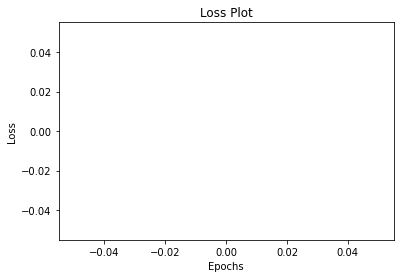

In [ ]:
# It doesnt display plot because cell was run after model had been trained and weights have been saved
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> dog walking along snow drift <end>
Prediction Caption: lollipop fending sippy footrace seating already cheering consulting support garland handlebars exercising stretching roadside teammate backbend damaged chairs tambourines machinery defenders teddy unconventional darts tasting washing thumbs multistory muzzles play marlins tired design


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


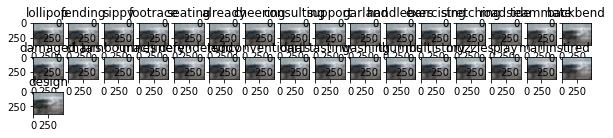

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)




print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_train))
image = img_name_train[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Image captioning with a Transformer Model


In [ ]:
# Define custom Encoder model here:
# Encoder layer uses 3 subtransformers with multihead attention each to process the image, uses adrop out and layer normaliation layer
# Transfomer model was implemented from research paper

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttentions(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training):

    attn_output, attention_weights = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2 ,attention_weights


class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    #self.pos_encoding = positional_encoding(maximum_position_encoding, 
     #                                       self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    #self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training):

    for i in range(self.num_layers):
      x , attention_weights= self.enc_layers[i](x, training)

    return x ,attention_weights


In [ ]:
# positional encoding

def get_angles(position,i, d):
  angle = 1/ np.power(10000, (2 * (i //2)/ np.float32(d)))
  return position * angle

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis,:] , d_model)

  # Encoding for even positions : 2i
  angle_rads[:, ::2] = np.sin(angle_rads[:, ::2])
  #Encoding for odd positioins
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)



In [ ]:
## Define mask
# padding_mask

def create_padding_mask(inp):
  mask = tf.cast(tf.math.equal(inp, 0), dtype=tf.float32)
  # expand dimensions to allow addtion of attention_logits

  return inp[:, np.newaxis, np.newaxis, :] # (batch_size, 1,1, seq_len)

# look_ahead_mask
def create_look_ahead_mask(seq_len):
  mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1, 0)
  return mask

In [ ]:
create_look_ahead_mask(2)

In [ ]:
# define scaled_dot_product_attention

def scaled_dot_product_attention(q, k, v, mask=None):
  # k, v are encoder outputs in this scenario.
  # mask must be broadcastable

  matmul_qk = tf.matmul(q, k , transpose_b=True) # (batch_size, seq_q, seq_k)
  d = tf.math.sqrt(tf.cast(tf.shape(k)[-1], dtype=tf.float32))

  scaled_attention_logits = matmul_qk / d

  # add mask if not none
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

  output = tf.matmul(attention_weights, v)  #(batch_size, seq_q, depth)

  return output, attention_weights


def scaled_dot_product_attentions(q, k, v, decoder = True):
  # k, v are encoder outputs in this scenario.
  # mask must be broadcastable
  # seq_q == seq_k == f_map == 64
  #q shape == (batch_size, 3, numheads, f_map, depth)
  #k shape == (batch_size, 3, numheads, f_map, depth)
  #v shape =- (batch_size, 3, numheads, f_map, depth)

  matmul_qk = tf.matmul(q, k , transpose_b=True) # (batch_size, 3, numheads, f_map(q), f_map(k))
  #print(matmul_qk.shape)
  d = tf.math.sqrt(tf.cast(tf.shape(k)[-1], dtype=tf.float32))

  scaled_attention_logits = matmul_qk / d


  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  #print(attention_weights.shape)
  #print('v_shape',v.shape)
  #print('q_shape',q.shape)
  #print('k_shape',k.shape)

  output = tf.matmul(attention_weights , v)  #(batch_size, 3, numheads, f_map(q), depth)
  

  return output, attention_weights


# Define multihead attentions class

class MultiHeadAttentions(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttentions, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % num_heads == 0
    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.wk2 = tf.keras.layers.Dense(d_model)
    self.wv2 = tf.keras.layers.Dense(d_model)

    self.wk3 = tf.keras.layers.Dense(d_model)
    self.wv3 = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, [batch_size, -1, self.num_heads, self.depth])
    return tf.transpose(x, [0,2,1,3])

  def call(self, q, k, v, decoder= False):
    # image shape after fc == ( batch_size, 64, d_model)
    batch_size = tf.shape(q)[0]
    f_map_q = tf.shape(q)[1]
    f_map_k  = tf.shape(k)[1]
    q = self.wq(q)
    v = self.wv(v)
    k = self.wk(k)
    v2= self.wv2(v)
    k2 = self.wk2(k)
    v3 = self.wv3(v)
    k3= self.wk3(k)

    q= tf.concat([self.split_heads(q, batch_size), self.split_heads(q, batch_size), self.split_heads(q, batch_size)], axis=1) # (batch_size, num_heads, f_map , depth )
    k = tf.concat([self.split_heads(k, batch_size),self.split_heads(k2, batch_size), self.split_heads(k3,batch_size)],axis=1)
    v = tf.concat([self.split_heads(v, batch_size), self.split_heads(v2, batch_size), self.split_heads(v3, batch_size)], axis=1)

    q = tf.reshape(q, (batch_size, 3, self.num_heads, f_map_q, self.depth)) # shape == (batch_size, 3, num_heads, f_map(q), depth)
    k =tf.reshape(k, (batch_size, 3, self.num_heads, f_map_k, self.depth))  # shape == (batch_size,3, num_heads, f_map(k), depth)
    v = tf.reshape(v, (batch_size, 3, self.num_heads, f_map_k,self.depth)) # shape == (batch_size, 3, num_heads, f_map(k), depth)
    #print(f' Shapes: q_shape = {q.shape}, k_shape= {k.shape}, v_shape= {v.shape}')

    # scaled_attention_shape == (batch-size, 3, numheads, f_map(q), depth)
    scaled_attention, attention_weights = scaled_dot_product_attentions(q, k, v)

    scaled_attention = tf.transpose(scaled_attention, [0,1,2,3,4]) # (batch_size, 3, f_map(q), numheads, depth)
    #attention_weights = tf.transpose(attention_weights, [0,2,1,3])

    concat_attention = tf.reshape(scaled_attention, [batch_size, -1, f_map_q, self.d_model]) #(batch_size, 3, f_map(q), d_model)
    output = self.dense(concat_attention) #(batch_size, 3 ,f_map(q), d_model)

    # output.shape == ( batch_size, f_map(q), d_model)
    if decoder:
      output = tf.reduce_mean(output, axis=1)
    else:
      output  = tf.reduce_sum(output, axis=1)

    return output, attention_weights 


# Define multihead attention class

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % num_heads == 0
    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, [batch_size, -1, self.num_heads, self.depth])
    return tf.transpose(x, [0,2,1,3])

  def call(self, q, k, v, mask=None):
    batch_size = tf.shape(q)[0]
    q = self.wq(q)
    v = self.wv(v)
    k = self.wk(k)
    
    q= self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)


    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, [0,2,1,3])
    #attention_weights = tf.transpose(attention_weights, [0,2,1,3])

    concat_attention = tf.reshape(scaled_attention, [batch_size, -1, self.d_model])
    output = self.dense(concat_attention)

    return output, attention_weights #(batch_size, seq_len_q, d_model)


In [ ]:
# Point wise feed forward network

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential(
      [tf.keras.layers.Dense(dff, activation='relu'),
       tf.keras.layers.Dense(d_model)]
  )

# Decoder Layer

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, word_d_model,  num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(word_d_model, num_heads)
    self.mha2 = MultiHeadAttentions(word_d_model,num_heads)

    self.ffn = point_wise_feed_forward_network(word_d_model, dff)

    # Layer normalization for each sublayer
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for each sublayer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, mask):
    # enc_output.shape == (batch_size, ..., d_model)

    attn1 , attn_weights_block1 = self.mha1(x, x, x, mask) #(batch_size, seq_q, word_d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1( x + attn1)

    attn2 , attn_weights_block2 = self.mha2(out1, enc_output, enc_output, True) # (batch_size, fmap(out1), d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    # feed forward network
    ffn_output= self.ffn(out2)

    ffn_output = self.dropout3(ffn_output, training= training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2



In [ ]:
# Decoder 

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, word_d_model, num_heads, dff, tar_vocab_size, max_position_encoding, rate= 0.1):
    super(Decoder, self).__init__()
    #print( num_layers % num_heads)
    #print( num_layers , d_model)
    self.d_model = word_d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(tar_vocab_size, word_d_model)
    self.pos_encoding = positional_encoding(max_position_encoding, word_d_model)

    self.dec_layers = [DecoderLayer(word_d_model, num_heads, dff, rate) for  _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training= training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x,enc_output, training, mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    return x, attention_weights

In [ ]:
# Define Transformer model that consists of embedding layer, position encoding layer and N decoder layers

class Transformer(tf.keras.Model):
  def __init__(self, enc_num_layers, dec_num_layers, enc_d_model, dec_d_model, num_heads, dff, target_vocab_size, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    #print(enc_d_model/ num_heads, dec_d_model/num_heads)
    self.tokenizer = Encoder(enc_num_layers, enc_d_model, num_heads, dff, rate)
    #print(dec_d_model)
    self.decoder = Decoder(dec_num_layers, dec_d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, mask):

    enc_output , attention_weights = self.tokenizer(inp, training)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, _ = self.decoder(tar, enc_output, training, mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights


In [ ]:
#num_layers= 4
enc_d_model = 2048
dec_d_model = 256
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
# Optimizer

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = tf.cast(d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(dec_d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2=0.98, epsilon= 1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')


In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_  = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)



In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
enc_num_layers = 3
dec_num_layers = 1
transformer = Transformer(enc_num_layers= enc_num_layers,
    dec_num_layers=dec_num_layers,
    enc_d_model = enc_d_model,
    dec_d_model = dec_d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size= vocab_size, 
    pe_target=40,
    rate=dropout_rate)

In [ ]:
def create_masks(tar):
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  return  look_ahead_mask

In [ ]:
checkpoint_path = './Checkpoints/Transformer/train'

ckpt = tf.train.Checkpoint(transformer = transformer,
                           optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Checkpoint Restored')

In [ ]:
ckpt_manager.latest_checkpoint

In [ ]:
EPOCHS = 15

train_step_signature = [
                        tf.TensorSpec(shape=(None, None)),
                        tf.TensorSpec(shape=(None, None))
]

@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:,1:]

  mask = create_masks(tar_inp)

  with tf.GradientTape() as tape:
    predictions , _  = transformer(inp, tar_inp, True, mask)

    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
 

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')



  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {(time.time() - start)/60:.2f} mins\n')



Epoch 1 Batch 0 Loss 9.0503 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9081 Accuracy 0.0277
Epoch 1 Batch 100 Loss 8.7344 Accuracy 0.0669
Epoch 1 Batch 150 Loss 8.5249 Accuracy 0.0818
Epoch 1 Batch 200 Loss 8.2840 Accuracy 0.0900
Epoch 1 Batch 250 Loss 8.0055 Accuracy 0.0964
Epoch 1 Batch 300 Loss 7.7189 Accuracy 0.1022
Epoch 1 Batch 350 Loss 7.4448 Accuracy 0.1108
Epoch 1 Batch 400 Loss 7.2067 Accuracy 0.1210
Epoch 1 Batch 450 Loss 6.9958 Accuracy 0.1306
Epoch 1 Batch 500 Loss 6.8081 Accuracy 0.1400
Epoch 1 Loss 6.6817 Accuracy 0.1475
Time taken for 1 epoch: 97.66 mins

Epoch 2 Batch 0 Loss 4.7398 Accuracy 0.2684
Epoch 2 Batch 50 Loss 4.7693 Accuracy 0.2661
Epoch 2 Batch 100 Loss 4.6692 Accuracy 0.2752
Epoch 2 Batch 150 Loss 4.5755 Accuracy 0.2864
Epoch 2 Batch 200 Loss 4.4855 Accuracy 0.2962
Epoch 2 Batch 250 Loss 4.3930 Accuracy 0.3068
Epoch 2 Batch 300 Loss 4.3184 Accuracy 0.3165
Epoch 2 Batch 350 Loss 4.2462 Accuracy 0.3257
Epoch 2 Batch 400 Loss 4.1755 Accuracy 0.3348
Epoch 2 Batch 

In [ ]:
#transformer.save_weights('/transformer_weights')
#transformer.load_weights('/transformer.h5')

In [ ]:
def evaluate_transformer(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    #print(img_tensor_val.shape)
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    #print(output)
    #result = []

    for i in range(max_length):
        look_ahead_mask = create_masks(output)
        #print(look_ahead_mask)
        predictions, attention_weights = transformer(img_tensor_val, output, False, look_ahead_mask)
        #print(predictions.shape)

        predictions = predictions[:, -1:, :] # (batch_size, 1 , 1)
        predicted_id = tf.argmax(predictions, axis=-1)
        print(predictions.shape)

        output = tf.concat([tf.cast(output,tf.int64), predicted_id], axis= -1)
        #print(tokenizer.index_word[value])
        id = int(predicted_id)
        if tokenizer.index_word[id] == '<end>':
            break
    
    result = (tokenizer.index_word[output]
    #print(result)
    return result , attention_weights


In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result = evaluate_transformer(image)

print(type(result))


print ('Real Caption:', real_caption)
print ('Prediction Caption:', result)
Image.open(image)